Recommendation Systems! Part 1: From Scratch

I call this a part 1 because I'll end up with many different parts to this blog post in the process of demonstrating the idea behind the recommendation system. For instance, this code as it stands actually won't ever become part of the actual recommendation system for reasons I'll talk about at the end. Instead, you can look forward to the Databricks notebook I'll have later that demonstrates more an Apache Spark way of doing it that'll be less math-y and a whole lot more computer science-y.

But either way, with the organization preliminaries out of the way, let's get onto the fun stuff: math!

## The setting:

Something really satisfying to me about this particular data science idea here is that the idea of recommendations (a set of users rating a set of movies/shows/books) is that all the data already has a really nice representation as a matrix! For example, you could imagine that a group of friends rating movies they've seen written out in a format like this:

![image.png](https://takuti.github.io/Recommendation.jl/latest/assets/images/cf.png)

*Image credit: https://takuti.github.io/Recommendation.jl/latest/collaborative_filtering/*
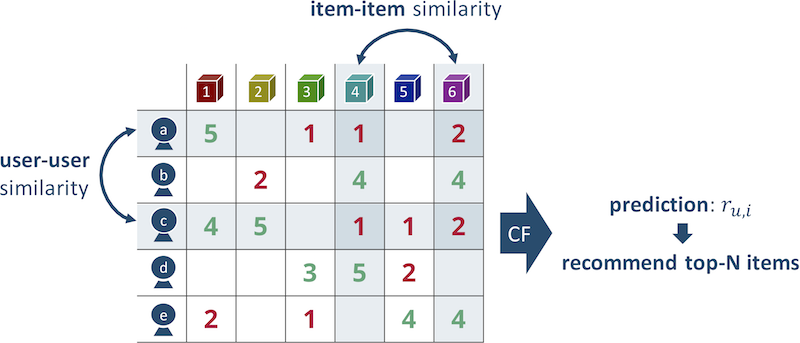

From here, I think it becomes pretty clear what our machine learning task is: we start with a *sparse* (fancy word for very unfilled) matrix, call it $R$ for ratings, and we want to fill in, or "complete" $R$. And of course, completing the matrix is nothing more than exactly the predictions we are making, guesses at what the user would have rated a certain movie. 

You can also see why it's called *collaborative* filtering, because for instance user C as depicted above is like "yo, let me see your homework" to everyone else, and then they all collaborate to help filter out the movies/items that this user will like. Maybe we can filter out that movie 3 as a bad recommendation for user C because their profile is rather similar to user A, who did not like movie 3.

As I like to say, let's start with the packages any good data-y project should start with: `numpy` and `pandas`.

In [1]:
import numpy as np
import pandas as pd

In [2]:
from sklearn.metrics import mean_squared_error

And now of course let's bring in the datasets straight from Kaggle. 

In [3]:
anime_data=pd.read_csv('anime.csv')
rating_data=pd.read_csv('rating.csv')
anime_data.shape

(12294, 7)

In [4]:
anime_data.head()

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


The `anime_data` dataset should be pretty self explanatory hopefully. The highlights here are that each anime has an `anime_id` which actually comes straight from the popular site [MyAnimeList](https://myanimelist.net/). For example, going to https://myanimelist.net/anime/32281 brings you directly to the page for Your Name (Kimi no Na wa.)

There is a `rating` column, but that's each anime's average rating over all user ratings, not on a per-user basis.

To get the per-user basis, we need the second dataset, `rating_data`.

In [5]:
rating_data.head()

,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1


And now that you know what the `anime_id` is, maybe this dataset is a little more clear now: we have a single row for *every single* rating that happened, so the first row is user 1 rating anime 20, then the next row is user 1 rating anime 24, and so on.

Not only that, but you can also see a ton of -1 entries. These actually indicate a lack of a rating, that user 1 actually didn't rate 20 at all. So there are a guaranteed 12294 entries for every single user, most of which are -1's, but that's why this dataset is absolutely enormous.

In [6]:
rating_data.shape

(7813737, 3)

This means around 7.8 million ratings total.

By the way, no one ever told me about `.info` from `pandas`, but it's actually pretty neat if you haven't see it either.

In [7]:
anime_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12294 entries, 0 to 12293
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   anime_id  12294 non-null  int64  
 1   name      12294 non-null  object 
 2   genre     12232 non-null  object 
 3   type      12269 non-null  object 
 4   episodes  12294 non-null  object 
 5   rating    12064 non-null  float64
 6   members   12294 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 672.5+ KB


It's a bit ugly (reminds me of some of that R hypothesis testing stuff), but it's pretty nice. From this, we can also see that there are 12294 total anime here.

We can do the same for the ratings dataset.

In [8]:
rating_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7813737 entries, 0 to 7813736
Data columns (total 3 columns):
 #   Column    Dtype
---  ------    -----
 0   user_id   int64
 1   anime_id  int64
 2   rating    int64
dtypes: int64(3)
memory usage: 178.8 MB


And we can also see that the ratings take up a good amount of memory. We'll be cutting down on this later, but yeah, normally this amount of data wouldn't fly.

With the explanation out of the way, we take the first standard step: cleaning and reshaping. The first and foremost thing to do remove all of those -1 entries, as that is sort of "non-information". This can simply be done by replacing them with `NaN` and dropping na.

In [9]:
anime_fulldata=pd.merge(anime_data,rating_data,on='anime_id',suffixes= ['', '_user'])
anime_fulldata = anime_fulldata.rename(columns={'name': 'anime_title', 'rating_user': 'user_rating'})
anime_fulldata.head()

,anime_id,anime_title,genre,type,episodes,rating,members,user_id,user_rating
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,99,5
1,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,152,10
2,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,244,10
3,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,271,10
4,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,278,-1


In [10]:
rating_data["rating"].replace({-1: np.nan}, inplace=True)
rating_data.head()

,user_id,anime_id,rating
0,1,20,NaN
1,1,24,NaN
2,1,79,NaN
3,1,226,NaN
4,1,241,NaN


In [11]:
rating_data = rating_data.dropna(axis = 0, how ='any') 
rating_data.isnull().sum()

user_id     0
anime_id    0
rating      0
dtype: int64

Now here's a really important step: we're going to be filtering again to **keep only users with over a certain number of ratings**. We're actually killing two birds with one stone. The first is pretty simple - this is another good step to reduce the size of our dataset.

But of course we're not throwing away data willy-nilly: the second reason we're doing this is that collaborative filtering as you may imagine does better when the matrix is less sparse. Users that have only say rated one single item aren't as much help. Just saying "oh, I really liked Attack on Titan" doesn't help our algorithm realize anything about another user who say liked Attack on Titan.

As you can see too, there are indeed a lot of users that have rated very few anime. The next line tells us how many anime each user has rated:

In [12]:
rating_data['user_id'].value_counts()

42635    3747
53698    2905
57620    2689
59643    2632
51693    2621
         ... 
3939        1
17218       1
11981       1
60619       1
69190       1
Name: user_id, Length: 69600, dtype: int64

(69600 users total). And look at what happens when I only want to see users that have rated more than 10 shows:

In [13]:
counts = rating_data['user_id'].value_counts()

In [14]:
counts[counts > 10]

42635    3747
53698    2905
57620    2689
59643    2632
51693    2621
         ... 
7865       11
39058      11
30115      11
4160       11
62278      11
Name: user_id, Length: 54204, dtype: int64

The number of valid users drops by like 15k, which is not far from a whole quarter of the dataset. In fact, maybe here's a better way to visualize:

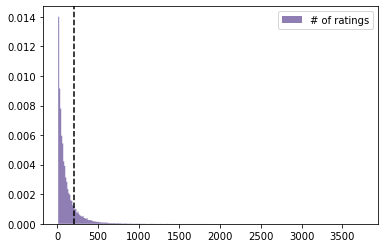

In [15]:
import matplotlib.pyplot as plt

plt.hist(counts[counts > 10], histtype = 'stepfilled', bins = 300,
         alpha = 0.85, label = '# of ratings', color = '#7A68A6', density = True)
plt.axvline(x = 200, color = 'black', linestyle = '--')
plt.legend(loc = "upper right")
plt.show()

So as you might expect, this is really right skewed, with lots of people leaving probably around 1-20 reviews in total, but notice that's only around 0.6% of all the ratings. Tossing away users that have very few ratings will still leave most of the data intact, and allow us to more easily format our data in the way that we want (with every user in the dataset having more than say 10 or 100 ratings).

After a bit of experimenting, I found that cutting off at 200 ratings seemed to work pretty well (i.e. only consider users that have rated at least 200 anime). I drew a vertical at around this mark to show how much of the data we'd be cutting off.

In [16]:
counts = rating_data['user_id'].value_counts()
rating_data = rating_data[rating_data['user_id'].isin(counts[counts >= 200].index)]

And now we use the very fancy `.pivot_table` to basically reshape the very "tall" ratings data into the "wider" format we want, with each column representing a show, and each row representing a user.

(BTW, this is the step would make any computer very sad if you tried to do this on the full dataset without filtering. The error message I got when I first tried said something like needed 6 GiB to store.)

In [17]:
anime_pivot=rating_data.pivot_table(index='user_id',columns='anime_id',values='rating').fillna(0)
anime_pivot.head()

anime_id,1,5,6,7,8,15,16,17,18,19,...,34238,34239,34240,34252,34283,34324,34325,34349,34367,34475
user_id,,,,,,,,,,,,,,,,,,,,,
5,0.0,0.0,8.0,0.0,0.0,6.0,0.0,6.0,6.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17,0.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,...,0.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
38,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
43,10.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Oohh, I think that looks pretty fancy now. Just again to get a better idea of what happened, here's the shape now.

In [24]:
cols = anime_pivot.columns
bt = anime_pivot.apply(lambda x: x > 0)
my_list = bt.apply(lambda x: list(cols[x.values]), axis=1)[5]


anime_id
7647     10.0
7674     10.0
15335    10.0
15417    10.0
20507    10.0
Name: 46, dtype: float64

In [25]:

anime_pivot.iloc[5][my_list].sort_values(ascending=False).head(20)

anime_id
7647     10.0
7674     10.0
15335    10.0
15417    10.0
20507    10.0
1535     10.0
6347     10.0
15775    10.0
23289    10.0
199      10.0
5680     10.0
269      10.0
16866    10.0
3702     10.0
245      10.0
3655     10.0
3588     10.0
18153    10.0
18179    10.0
7791     10.0
Name: 46, dtype: float64

In [44]:
anime_pivot.shape

(8713, 9819)

So this is simply indicating that after our filtering, we have 8713 users (down from 69600) rating 9819 anime (down from 12294). The higher frop in number of users should make a bit of sense - one way of thinking about it is that the dropped anime are "obscure" anime, but there are a lot more "obscure" users than anime in standard rating websites.

Either way, we're pretty done for now with all of the pandas tools, so let's get this out of a DataFrame and into a numpy matrix where it'll be easier to "do math" on a matrix. 

In [45]:
ratings = anime_pivot.to_numpy()

Now that the data is in more or less the right shape now, let's take a peek at some of it. This includes calculating the sparsity. (Recall that usually ratings matrices are sparce because it's very unlikely that most users have rated most of the ~10k shows in our dataset).

In [46]:
matrix_size = np.prod(ratings.shape)
interaction = np.flatnonzero(ratings).shape[0]
sparsity = 100 * (interaction / matrix_size)

In [47]:
print('dimension: ', ratings.shape)
print('sparsity: {:.1f}%'.format(sparsity))
ratings

dimension:  (8713, 9819)
sparsity: 3.7%


array([[0., 0., 8., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 7., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [9., 7., 9., ..., 0., 0., 0.],
       [9., 8., 9., ..., 0., 0., 0.]])

And so our sparsity is around 3.7%, which actually is an alright number. A heuristic I often hear is that 1% is the lower bound for amounts of data you can perform reasonable analysis on. Would have liked it to be a bit higher, but whenever I did things like increasing the number of ratings cutoff, we ended up with worse accuracy numbers.

Now the final step in most good machine learning notebooks: the test-train split. I did this a bit more manually 

In [48]:
def create_train_test(ratings):
    """
    split into training and test sets,
    remove 10 ratings from each user
    and assign them to the test set
    """
    test = np.zeros(ratings.shape)
    train = ratings.copy()
    for user in range(ratings.shape[0]):
        test_index = np.random.choice(
            np.flatnonzero(ratings[user]), size = 50, replace = False)

        train[user, test_index] = 0.0
        test[user, test_index] = ratings[user, test_index]
        
    # assert that training and testing set are truly disjoint
    assert np.all(train * test == 0)
    return train, test

train, test = create_train_test(ratings)
del ratings
train

array([[0., 0., 8., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [9., 7., 9., ..., 0., 0., 0.],
       [9., 8., 9., ..., 0., 0., 0.]])

And with that, pretty much all of the data preparation is taken care of. So now we can *finally* start machine learning.

## The machine learning

The algorithm we'll be using is called **Alternating Least Squares (ALS)**. You'll see why in a second, but we have to set up some theory first. Recall that we're trying to "complete" this matrix $R$ (like completing a Sudoku puzzle).


The idea is to use matrix factorization, i.e. try to find matrices
$$
X = 
\begin{bmatrix}
    \vert & & \vert \\
    x_1  & \dots & x_n   \\
    \vert & & \vert
\end{bmatrix}
$$

$$
Y = 
\begin{bmatrix}
    \vert & & \vert \\
    y_1  & \dots & y_m   \\
    \vert & & \vert
\end{bmatrix}
$$

matrices such that $R \approx X^T Y$. Notice then that if we find such a factors $X,Y$, we'd have $r_{ui} \approx x_u^t y_i$. In other words, each $x_u$ represents one "factor" that summarizes user $u$ and, we multiply each factor to by the item summarized by $y_i$ to get recover the rating that would result from that user against that item. Normally of course, to make the optimization a lot more managable, these factor vectors would be in a much lower dimension than the size of $R$, like maybe around 10, or however many makes sense for your dataset to try to summarize each user/item. Then we use this loss function to minimize against:

$$
\text{min}_{X,Y} \sum_{r_{ui} \text{ observed}}(r_{ui} - x_u^T y_i)^2 + \lambda \left( \sum_u \|x_u\|^2 + \sum_i  \|y_i\|^2 \right)
$$

What's going on here? Notice that the first term is just a standard least squares loss function that penalizes us if of course we didn't get the original known ratings correct.

Then the second term is $\lambda$, which is called a *regularizer*. This basically means that we penalize (make the error worse) of attempts that have very high numbers in the $x_u$ or $y_i$ vector, which makes sense, we want a solution that keeps the numbers rather tame rather than extreme to keep the ratings as close to the 1-10 range as possible.

Now unfortunately this *almost* look convex, but it's not because of the $x_u^T y_i$ term. However, here's the key observation: if we don't minimize over both $X,Y$ at the same time, and instead treat $Y$ as fixed first and just optimize over possible $X$ matrices, we do have a convex function. (In fact, we'll essentially just have a least squares problem with a regularizer.)

Once that's optimized, we can just hold $X$ constant and optimize for $Y$, which is symmetrically convex. This could possibly mess up our optimization of $X$, so reverse and keep repeating until convergence.

Now we'll actually be implementing this as a Python class simply because we'll want to be storing a lot of instance variables and methods for easy access later.

In [56]:
class ALS:
    """
    A matrix factorization model using Alternating Least Squares
    to complete a ratings matrix
    
    Parameters
    ----------
    n_iters : int
        number of iterations to train the algorithm
        
    rank : int
        number of latent factors, the linear algebra thingy
        
    reg : float
        regularization term for item/user latent factors,
        normally called lambda but that's taken in python
    """

    def __init__(self, n_iters, rank, reg):
        self.reg = reg
        self.n_iters = n_iters
        self.rank = rank  
        
    def fit(self, train, test):
        """
        pass in training and testing at the same time to record
        model convergence, assuming both dataset is in the form
        of User x Item matrix with cells as ratings
        """
        self.n_user, self.n_item = train.shape

        # random initialization of X (matrix user factor columns)
        # and Y (matrix of item factor columns) 
        self.user_factors = np.random.random((self.n_user, self.rank))
        self.item_factors = np.random.random((self.n_item, self.rank))
        
        # for plotting, to see how error decreases
        self.test_mse_record  = []
        self.train_mse_record = []

        # main iteration
        for _ in range(self.n_iters):
            self.user_factors = self._als_step(train, self.user_factors, self.item_factors)
            self.item_factors = self._als_step(train.T, self.item_factors, self.user_factors) 

            # at every step, compute current predictions to get error
            predictions = self.predict()
            test_mse = self.compute_mse(test, predictions)
            train_mse = self.compute_mse(train, predictions)
            self.test_mse_record.append(test_mse)
            self.train_mse_record.append(train_mse)
        
        return self    
    
    def _als_step(self, ratings, solve_vecs, fixed_vecs):
        """
        when updating the user matrix,
        the item matrix is the fixed vector and vice versa
        """
        A = fixed_vecs.T.dot(fixed_vecs) + np.eye(self.rank) * self.reg
        b = ratings.dot(fixed_vecs)
        A_inv = np.linalg.inv(A)
        solve_vecs = b.dot(A_inv)
        return solve_vecs
    
    def predict(self):
        """predict ratings for every user and item"""
        pred = self.user_factors.dot(self.item_factors.T)
        return pred
    
    @staticmethod
    def compute_mse(y_true, y_pred):
        """ignore zero terms prior to comparing the mse"""
        mask = np.nonzero(y_true)
        mse = mean_squared_error(y_true[mask], y_pred[mask]) / (np.amax(y_true) - np.amin(y_true))
        return mse
    

A couple of highlights, notice that for all the matrix-y computation, we only needed one function. This is still thanks to the symmetry of the objective function in $X$ and $Y$: if you fix $X$ and optimize $Y$, the equation looks exactly the same as if you're fixing $Y$ and optimizing $X$, so we literally just switch the order of arguments when we call the single function.

By the way, mean square error is just a standard way of computing 

In [50]:
def plot_learning_curve(model):
    """visualize the training/testing loss"""
    linewidth = 3
    plt.plot(model.test_mse_record, label = 'Test', linewidth = linewidth)
    plt.plot(model.train_mse_record, label = 'Train', linewidth = linewidth)
    plt.xlabel('iterations')
    plt.ylabel('MSE')
    plt.title(f'rank = {model.rank}, reg = {model.reg}')
    plt.legend(loc = 'best')

And that's pretty much it! That's the machine learning! As far as I've seen it's pretty simple as far as machine learning algorithms go, but I still think that idea of "alternating" and optimizing one at a time to make the problem so much easier is really cool. Even more than that too, it's one of those ideas that someone who didn't know better might just throw out there and that you might expect to totally not work, but it actually does end up converging.

So now, like many standard machine learning practices, there are still a few knobs that we as the architects can turn to make further improvements. The most obvious ones we'll be tackling here are to change around those parameters for rank and regularization. I'll be doing this in a rather simple way, just rerunning the model over and over again with different parameters until we find one a set that minimizes the error. 

In [51]:
def test_ALS(factors, regs):
    min_error = float('inf')
    best_rank = -1
    best_regularization = 0
    best_model = None
    for factor in factors:
        for my_reg in regs:
            print(factor, my_reg)


            als = ALS(n_iters = 20, rank = factor, reg = my_reg)
            als.fit(train, test)

            plt.figure()

            plot_learning_curve(als)
            
            plt.show()
            print(f'{factor} latent factors and regularization = {my_reg}: validation RMSE is {als.train_mse_record[-1]}')
            if als.train_mse_record[-1] < min_error:
                min_error = als.train_mse_record[-1]
                best_rank = factor
                best_rank = my_reg
                best_model = als
                
    print('\nThe best model has {} latent factors and '
          'regularization = {}'.format(best_rank, best_regularization))
    return best_model


100 0.15


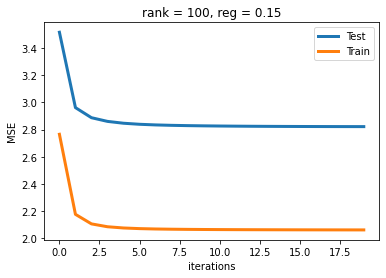

100 latent factors and regularization = 0.15: validation RMSE is 2.0629825922048317
100 0.2


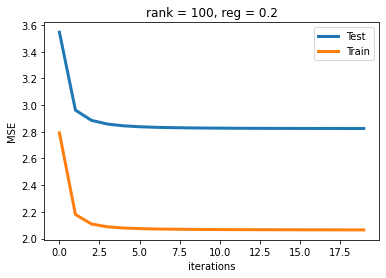

100 latent factors and regularization = 0.2: validation RMSE is 2.0645885054062694
100 0.25


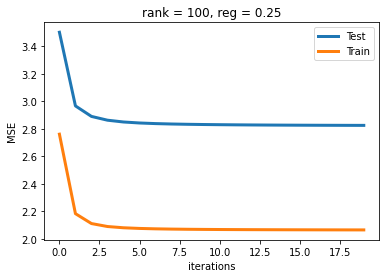

100 latent factors and regularization = 0.25: validation RMSE is 2.0651915286109905
200 0.15


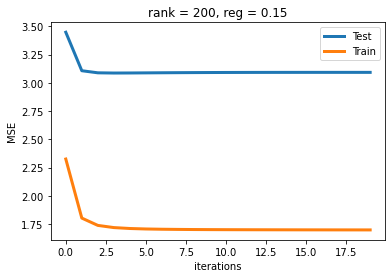

200 latent factors and regularization = 0.15: validation RMSE is 1.6989438453979033
200 0.2


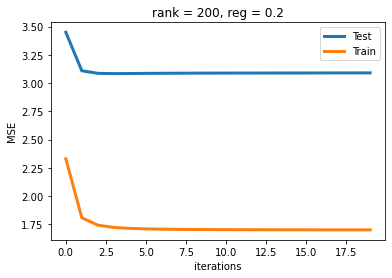

200 latent factors and regularization = 0.2: validation RMSE is 1.6998052179555423
200 0.25


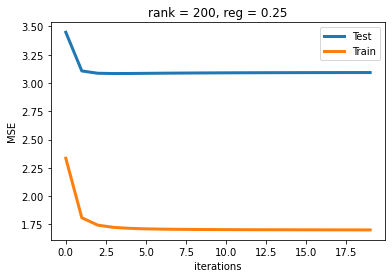

200 latent factors and regularization = 0.25: validation RMSE is 1.7009243667280873
300 0.15


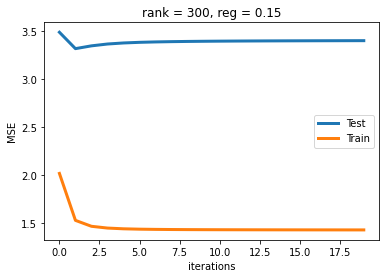

300 latent factors and regularization = 0.15: validation RMSE is 1.4319365065787886
300 0.2


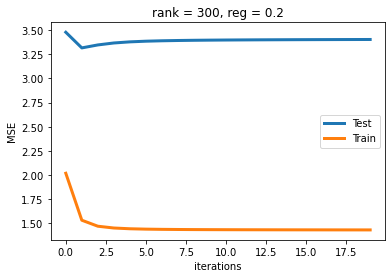

300 latent factors and regularization = 0.2: validation RMSE is 1.4331314315800647
300 0.25


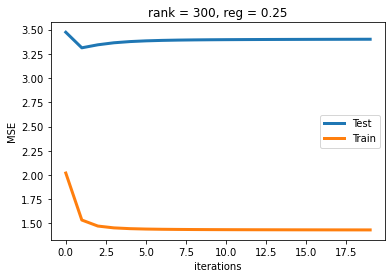

300 latent factors and regularization = 0.25: validation RMSE is 1.4337480456022065
400 0.15


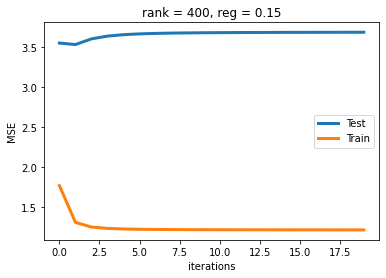

400 latent factors and regularization = 0.15: validation RMSE is 1.2189224538768477
400 0.2


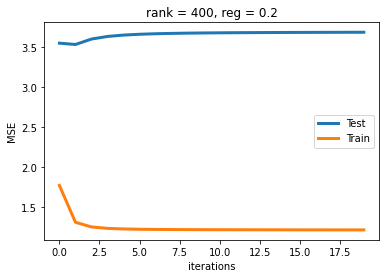

400 latent factors and regularization = 0.2: validation RMSE is 1.220164657281094
400 0.25


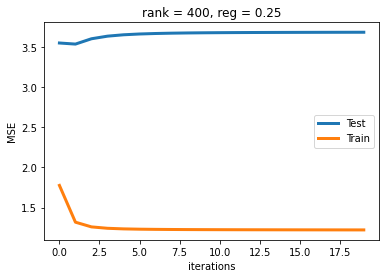

400 latent factors and regularization = 0.25: validation RMSE is 1.2209445028822967
500 0.15


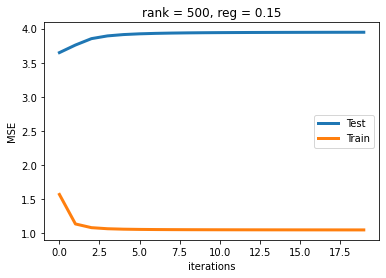

500 latent factors and regularization = 0.15: validation RMSE is 1.0456991188926468
500 0.2


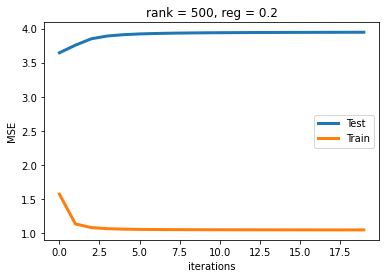

500 latent factors and regularization = 0.2: validation RMSE is 1.0467176552011828
500 0.25


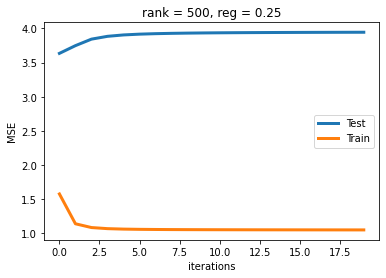

500 latent factors and regularization = 0.25: validation RMSE is 1.0478343728527022
600 0.15


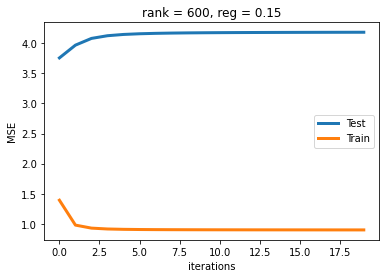

600 latent factors and regularization = 0.15: validation RMSE is 0.9009767772788353
600 0.2


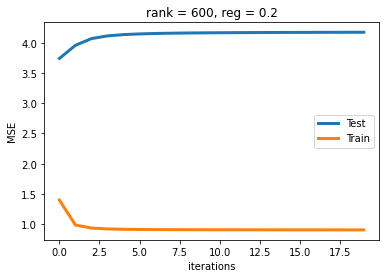

600 latent factors and regularization = 0.2: validation RMSE is 0.9021863737737588
600 0.25


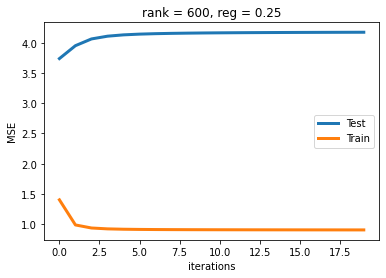

600 latent factors and regularization = 0.25: validation RMSE is 0.9031407089645205
700 0.15


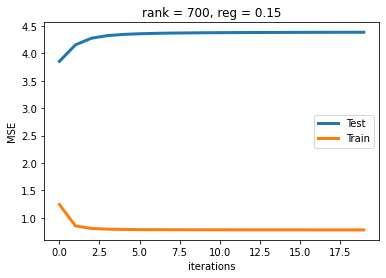

700 latent factors and regularization = 0.15: validation RMSE is 0.778942074072108
700 0.2


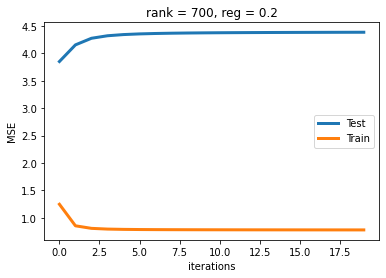

700 latent factors and regularization = 0.2: validation RMSE is 0.7799283174829428
700 0.25


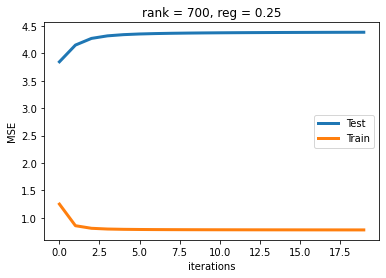

700 latent factors and regularization = 0.25: validation RMSE is 0.7808132441055287
800 0.15


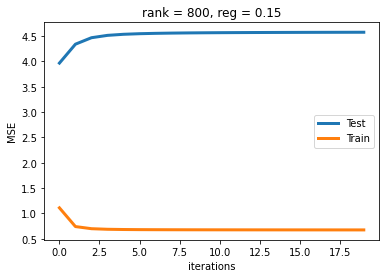

800 latent factors and regularization = 0.15: validation RMSE is 0.6752493857981295
800 0.2


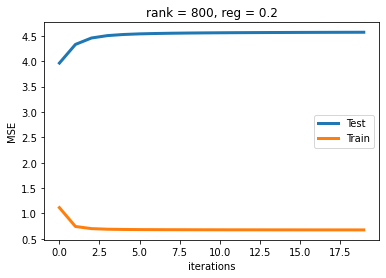

800 latent factors and regularization = 0.2: validation RMSE is 0.6762372769929852
800 0.25


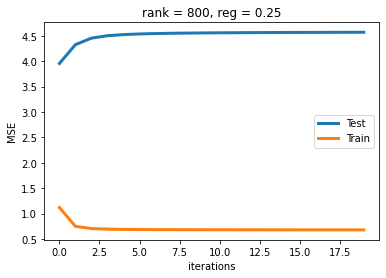

800 latent factors and regularization = 0.25: validation RMSE is 0.6772041449371212
900 0.15


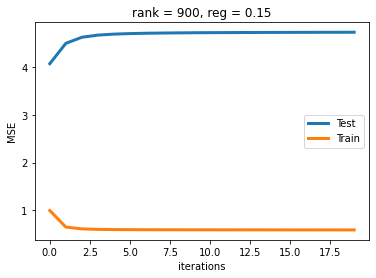

900 latent factors and regularization = 0.15: validation RMSE is 0.5864264259589638
900 0.2


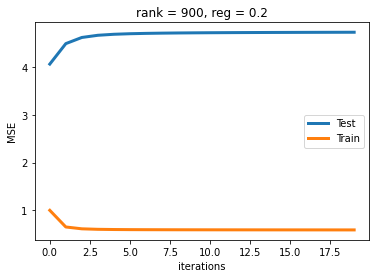

900 latent factors and regularization = 0.2: validation RMSE is 0.5872564472879721
900 0.25


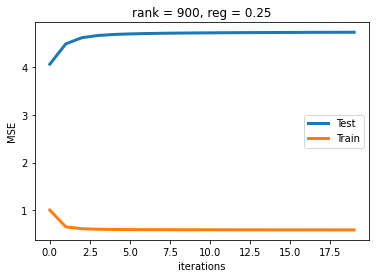

900 latent factors and regularization = 0.25: validation RMSE is 0.5880839764818996
1000 0.15


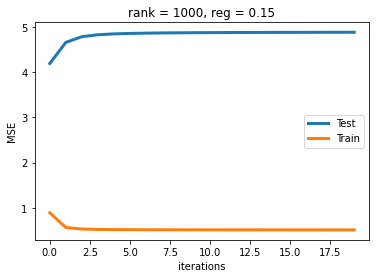

1000 latent factors and regularization = 0.15: validation RMSE is 0.5098030597726719
1000 0.2


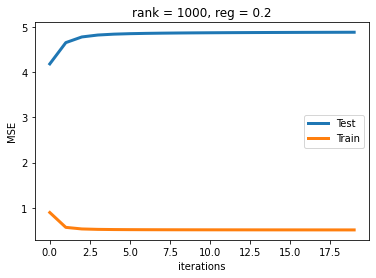

1000 latent factors and regularization = 0.2: validation RMSE is 0.5108041692369727
1000 0.25


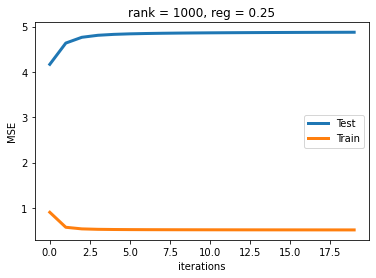

1000 latent factors and regularization = 0.25: validation RMSE is 0.5115036124585726

The best model has 0.15 latent factors and regularization = 0


In [59]:
best_als = test_ALS(np.linspace(100, 1000, 10).astype(int), [.15, .20, .25])

(And we get some pretty clear signs of overfitting past rank 200).

In [22]:
best_als.predict()

array([[ 2.56274937e+00,  1.16276848e+00,  3.21482109e+00, ...,
        -2.99449524e-02, -1.46400569e-02, -3.72779239e-04],
       [ 3.51537758e-01, -1.02474420e+00,  2.14228881e+00, ...,
        -1.34284410e-02,  1.99208294e-03,  9.94906979e-03],
       [ 4.09141195e+00,  1.70242472e+00,  3.15586421e+00, ...,
         3.09869749e-03,  7.17839259e-04,  2.68027908e-02],
       ...,
       [ 2.19355801e-01,  4.41395374e-01,  3.37594716e-01, ...,
         1.93705514e-03, -2.55587166e-04,  1.29430481e-02],
       [ 6.73220411e+00,  4.00699476e+00,  4.22009172e+00, ...,
        -3.37342630e-02,  1.35956518e-02,  6.27329934e-03],
       [ 6.72736354e+00,  4.75549634e+00,  5.00467333e+00, ...,
        -8.51482392e-03,  2.44434181e-03,  2.34263313e-03]])

But that's it now! This is our reconstructed ("learned") ratings matrix! With this information, we can now get 

In [23]:
df = pd.DataFrame(best_als.predict(), columns = anime_pivot.columns, index = anime_pivot.index)

In [24]:
df.head()

anime_id,1,5,6,7,8,15,16,17,18,19,...,34238,34239,34240,34252,34283,34324,34325,34349,34367,34475
user_id,,,,,,,,,,,,,,,,,,,,,
5,2.562749,1.162768,3.214821,0.293718,0.471657,2.827497,0.753208,1.159920,0.748092,1.215935,...,0.011473,0.007717,0.271801,0.014540,-0.015202,-0.000045,0.025190,-0.029945,-0.014640,-0.000373
7,0.351538,-1.024744,2.142289,0.068091,0.227317,0.928156,-2.087391,0.474109,0.090831,1.465056,...,0.007809,0.005742,-0.083864,0.001615,0.025667,-0.018983,0.036369,-0.013428,0.001992,0.009949
17,4.091412,1.702425,3.155864,-0.536683,-0.294676,0.426128,0.055513,-0.034629,0.127867,4.266287,...,0.193421,-0.009706,2.925138,0.000583,0.115008,0.026459,-0.058944,0.003099,0.000718,0.026803
38,0.887254,-0.388829,1.304103,-0.045049,-0.334334,0.326981,-0.558836,-0.062609,0.500415,0.952750,...,-0.078735,-0.004248,0.168934,-0.031152,0.052439,-0.004278,-0.050811,-0.025365,-0.003588,0.011929
43,4.146058,1.328764,2.461934,0.640694,0.180400,1.172276,-0.341378,-0.071348,-0.197650,0.750328,...,0.065064,0.021012,0.427438,0.001162,-0.032281,0.010966,-0.007738,-0.021349,-0.004984,-0.009888


In [25]:
anime_pivot.head()

anime_id,1,5,6,7,8,15,16,17,18,19,...,34238,34239,34240,34252,34283,34324,34325,34349,34367,34475
user_id,,,,,,,,,,,,,,,,,,,,,
5,0.0,0.0,8.0,0.0,0.0,6.0,0.0,6.0,6.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17,0.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,...,0.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
38,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
43,10.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


And so if we match up the entries, you'll see that while the entries are sort of "off" by some scaling, the entries that the user originally marked as high are also high in the predictions, which is a good "intuitive" sign that something's going right! Then the idea is that for a particular user, we can just find the highest entries that they haven't marked rated yet.

So now that we have all the prediction numbers, we can actually make some recommendations! The idea will be what was outlined just above. Implementing it will involve "zeroing" out all the entries that are nonzero (rated) using entrywise series multiplication for pandas.

Then, out of that whole list, sorting by top rated first will let those zero'd out ones we don't care about sink to the bottom, leaving only new shows.

In [26]:
list((df.loc[5] * (anime_pivot.loc[5] == 0)).sort_values(ascending=False)[:5].index)

[11061, 154, 11771, 18119, 30276]

And now we can just look up those ids with the original `anime.csv` dataset.

In [27]:
anime_data = anime_data.set_index("anime_id")

In [28]:
anime_data.loc[32281]['name']

'Kimi no Na wa.'

In [29]:
def generate_recommendations(userid, n=5):
    print("You really liked:")
    for liked in list(anime_pivot.loc[userid].sort_values(ascending=False)[:n].index):
        print(anime_data.loc[liked]['name'])
        
        
    print("\n\nAnd here are the recommendations")
    for recommended in list((df.loc[userid] * (anime_pivot.loc[userid] == 0)).sort_values(ascending=False)[:n].index):
        print(anime_data.loc[recommended]['name'])
        
generate_recommendations(5)

You really liked:
Gintama Movie: Kanketsu-hen - Yorozuya yo Eien Nare
Great Teacher Onizuka
Steins;Gate Movie: Fuka Ryouiki no Déjà vu
JoJo no Kimyou na Bouken (TV)
Detroit Metal City


And here are the recommendations
Hunter x Hunter (2011)
Shaman King
Kuroko no Basket
Servant x Service
One Punch Man


In [30]:
generate_recommendations(38)

You really liked:
Hellsing Ultimate
Magi: The Kingdom of Magic
Neon Genesis Evangelion: The End of Evangelion
Stranger: Mukou Hadan
Code Geass: Hangyaku no Lelouch


And here are the recommendations
Death Parade
Nanatsu no Taizai
Mahouka Koukou no Rettousei
Shingeki no Bahamut: Genesis
Zetsuen no Tempest


Nice! We can see that even these initial results make a good amount of sense. User id 5 seems to like lots of shounen/action anime so we got recommended One Punch Man, Hunter x Hunter, and Kuroko no Basket.

And user 38 also likes action shows, but more of the psychological/drama kind (Code Geass, Neon Genesis Evangelion), so we get recommended things like Death Parade and Zetsuen no Tempest.

Bonus points if you know all of those by the way, I certainly didn't haha

# Conclusion



But here's the thing: in actual apps and stuff, I really don't want to be reinventing the wheel. In other words, pretty much every famous machine learning algorithm under the sun has been *greatly* optimized, so why bother using this method that takes 20 minutes per run?

No, I'll go into more detail in the blog post, but I'll instead be using Databricks instead, and not gonna lie it's pretty magical.